## Import

In [ ]:
import random
import os
import itertools
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np
import xgboost as xgb
import sys
import tqdm as tq
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

import re
import time, os
import random
from tqdm import tqdm

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings(action='ignore')

from datetime import datetime, timedelta
from prophet import Prophet #prophet 라이브러리 불러오기

from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics

## Fixed Random-Seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed = 42
seed_everything(seed) # Seed 고정

## Load Data

In [ ]:
train_df = pd.read_csv(os.path.abspath("../data")+"/train.csv")
test_df = pd.read_csv(os.path.abspath("../data")+"/test.csv")
buildings = pd.read_csv(os.path.abspath("../data")+"/building_info.csv")

　  1 ~ 15  | 건물기타  
　 16 ~ 23  | 공공  
　 24 ~ 31  | 대학교  
　 32 ~ 36  | 데이터센터  
　 37 ~ 44  | 백화점 및 아울렛  
　 45 ~ 52  | 병원  
　 53 ~ 60  | 상용  
　 61 ~ 68  | 아파트  
　 69 ~ 76  | 연구소  
　 77 ~ 84  | 지식산업센터  
　 85 ~ 92  | 할인마트  
　 93 ~ 100 | 호텔 및 리조트

2022년 08월 25일부터 2022년 08월 31일까지의 전력사용량(kWh)을 예측 (목 ~ 수 7일간)

In [ ]:
lst_공공 = list(range(16,24))

In [ ]:
train_공공 = train_df[train_df['건물번호'].isin(lst_공공)]

In [ ]:
train_공공['일시'] = pd.to_datetime(train_공공['일시'])

In [ ]:
a = pd.DataFrame()

In [ ]:
for i in lst_공공:
    tt = train_공공[train_공공['건물번호']==i]
    tt = tt[['전력소비량(kWh)']].T
    tt.columns = train_공공[train_공공['건물번호']==16]['일시']
    tt.index = [i]
    a = pd.concat([a,tt], axis=0)

In [ ]:
rows_with_high_zeros = a

In [ ]:
train_list = []
test_list = []

In [ ]:
for i in range(len(rows_with_high_zeros)):
    data = rows_with_high_zeros.iloc[i, :].reset_index()  # 6번째 컬럼부터 끝까지 추출
    data.columns = ['date_time', 0]  # 컬럼 이름 변경
    train_list.append(data)

0 번 제품


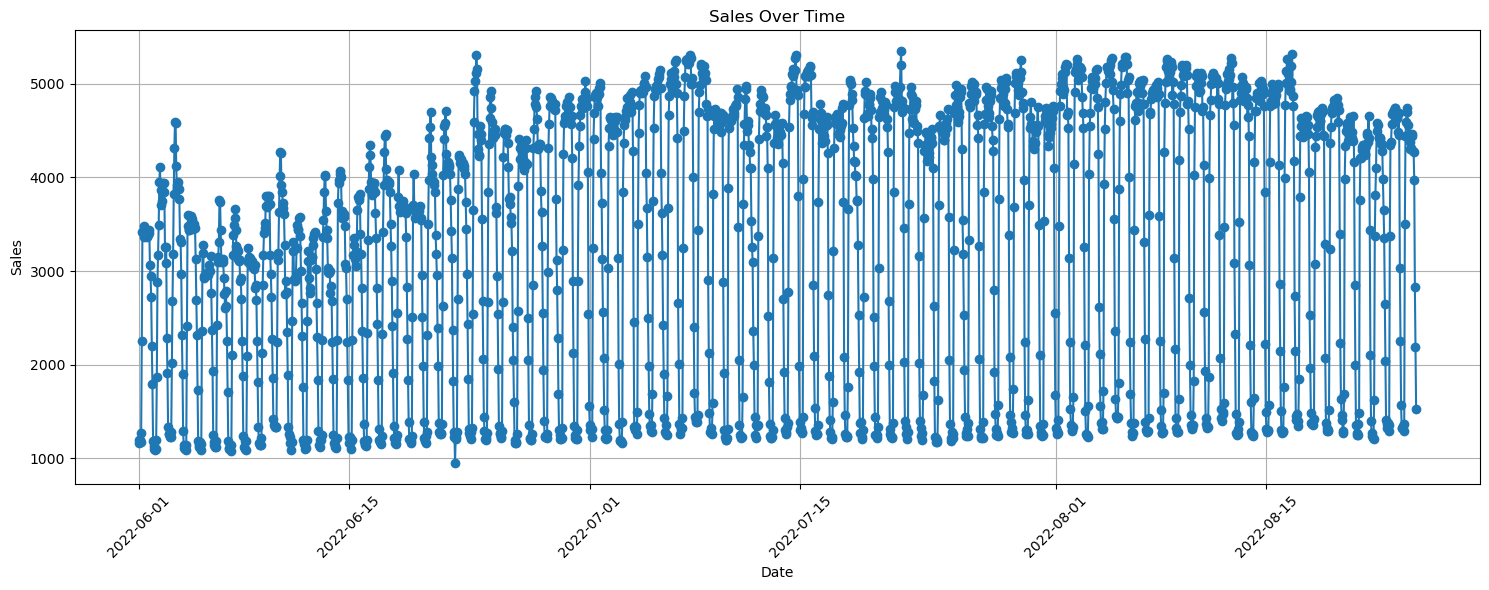

1 번 제품


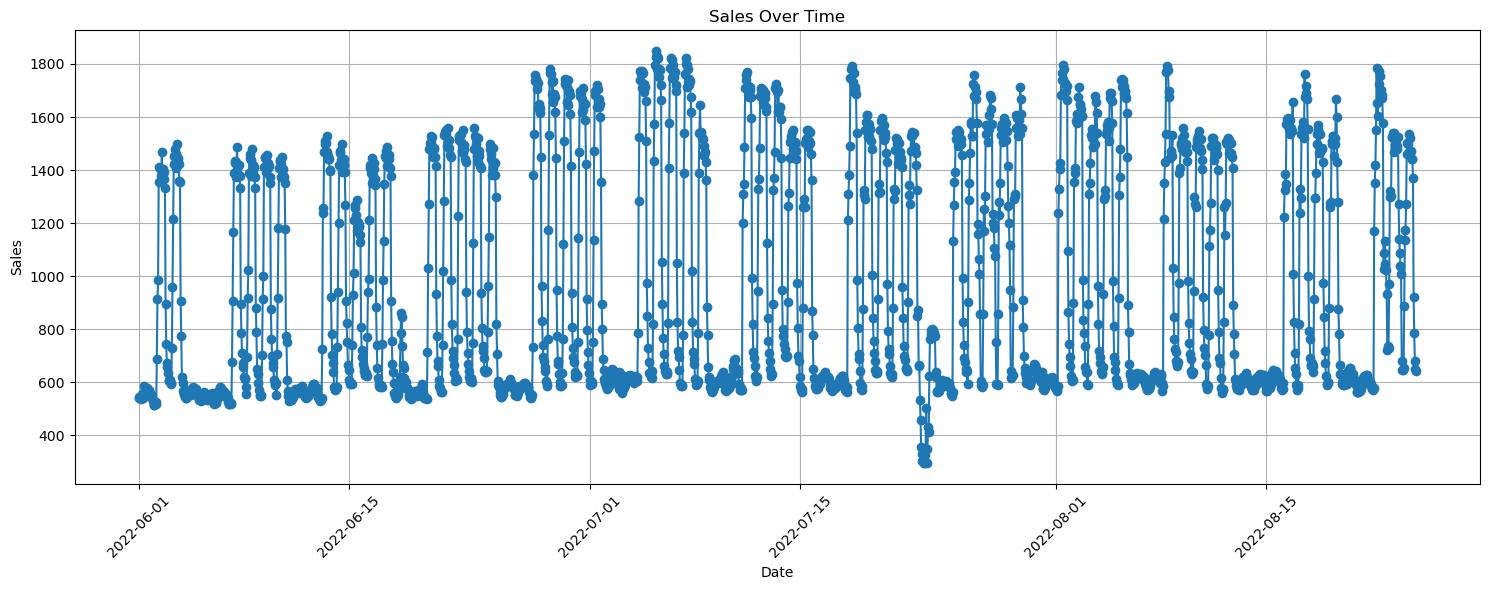

2 번 제품


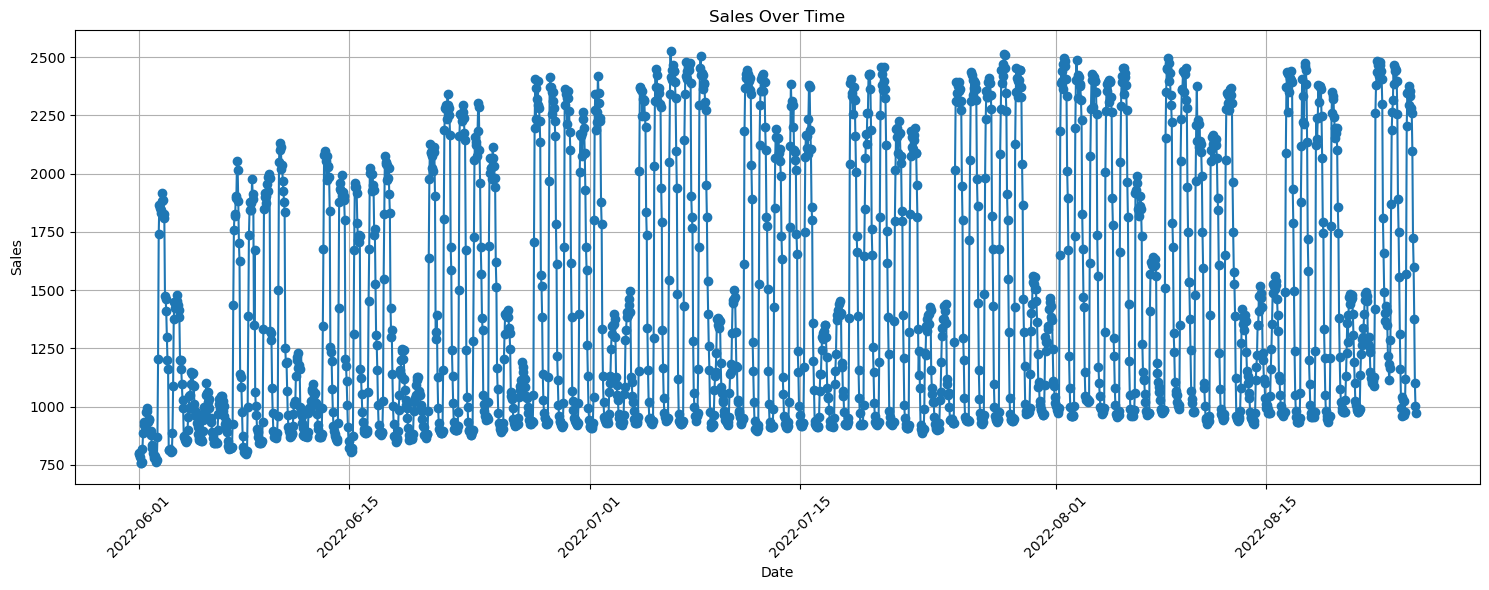

3 번 제품


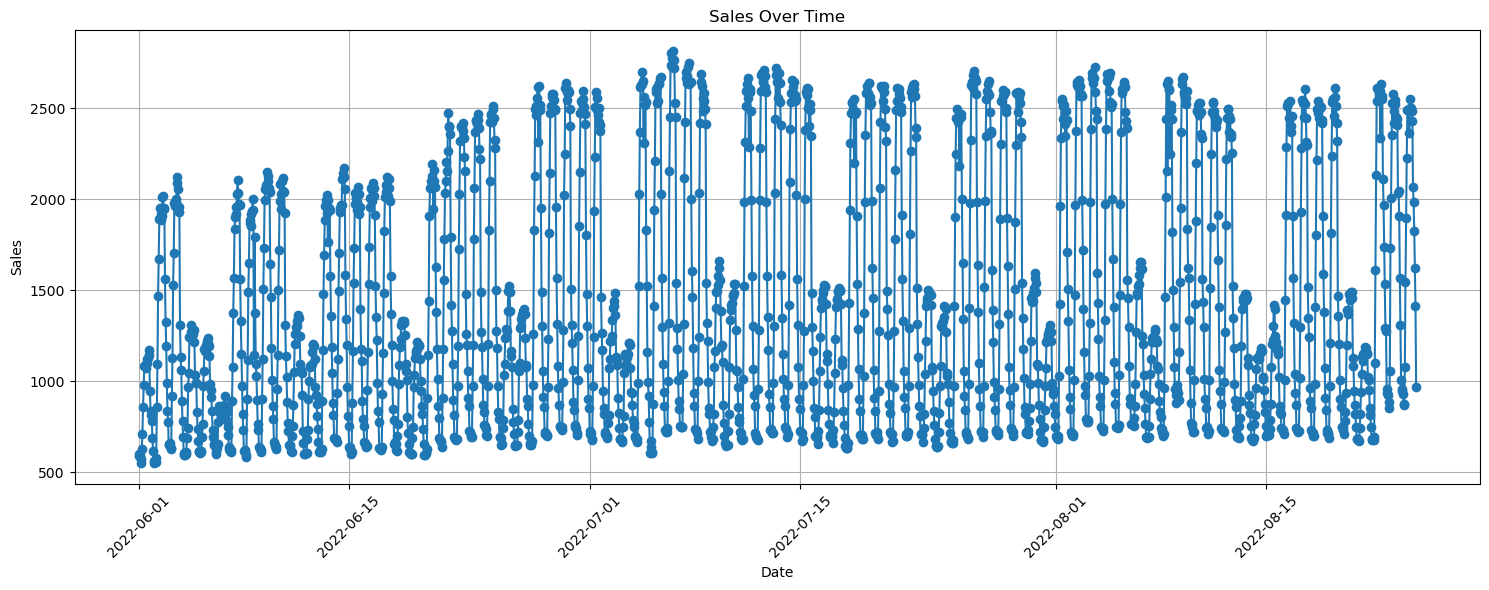

4 번 제품


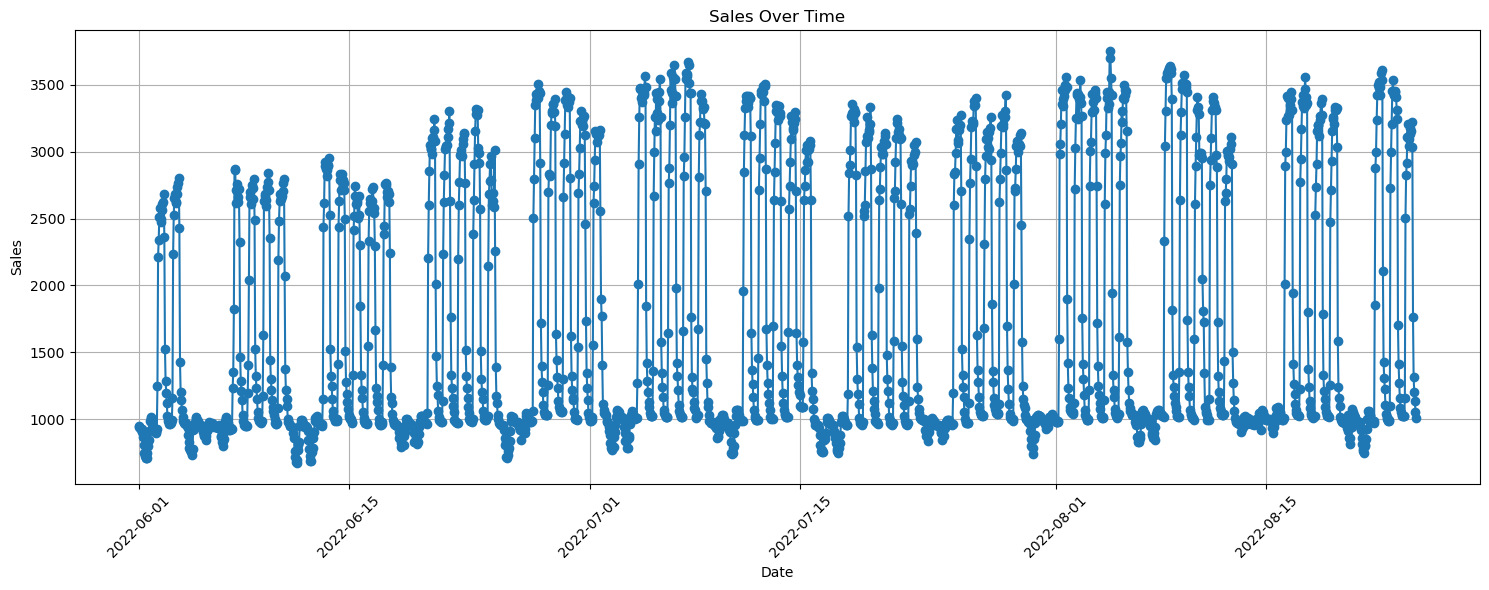

5 번 제품


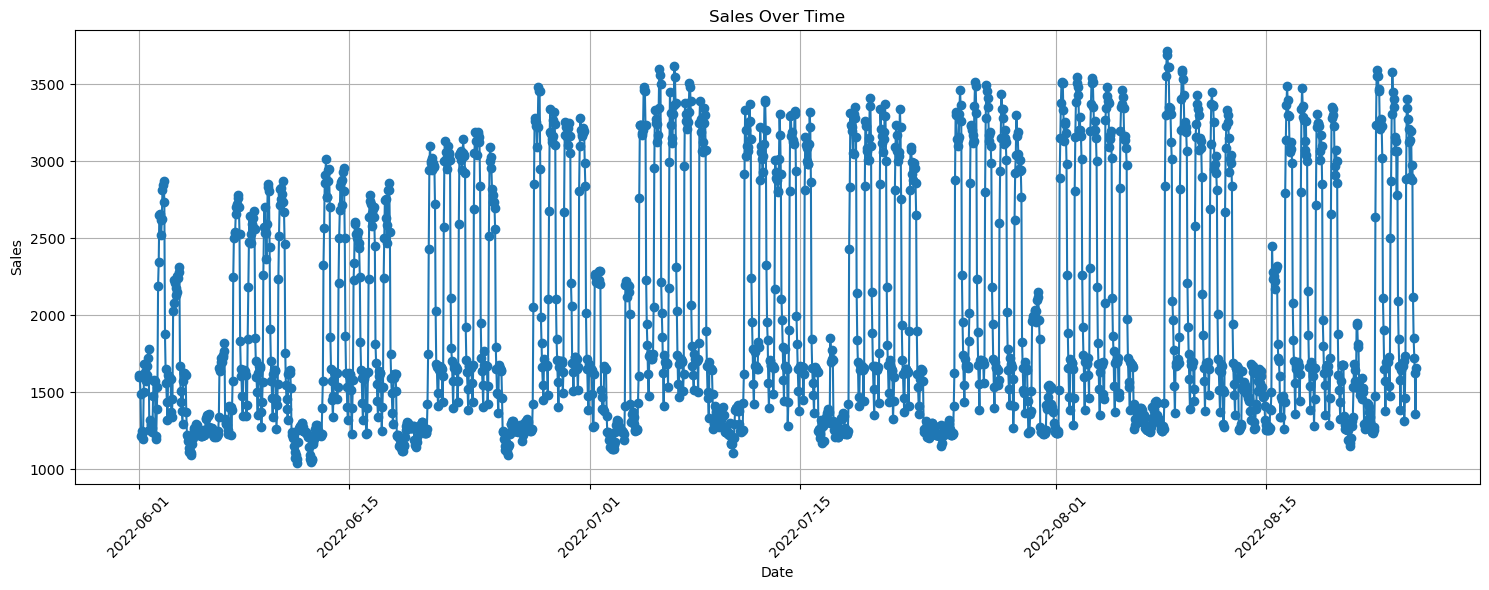

6 번 제품


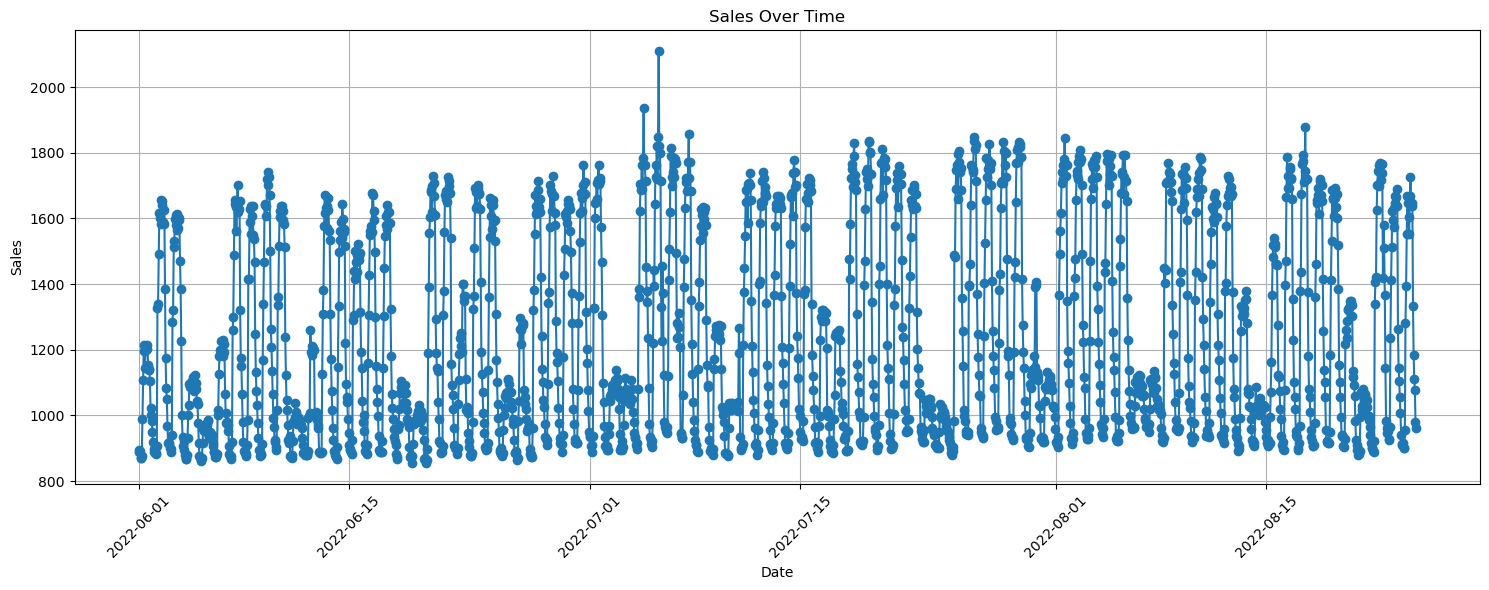

7 번 제품


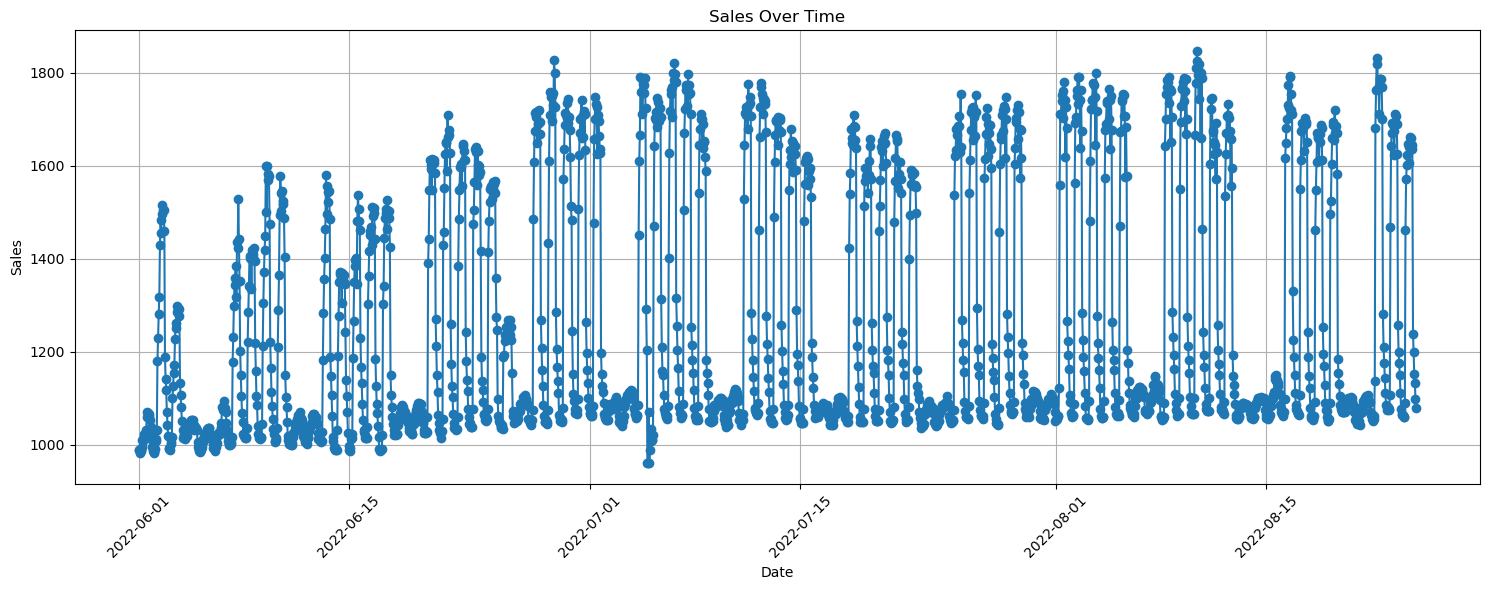

In [ ]:
for i in range(len(rows_with_high_zeros)):
    train_list[i]['date_time'] = pd.to_datetime(train_list[i]['date_time'])
    # 그래프 그리기
    plt.figure(figsize=(15, 6))
    plt.plot(train_list[i]['date_time'], train_list[i][0], marker='o')
    plt.title('Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    print(i,"번 제품")
    plt.show()

### ***공공기관은 첫번째 16번 제외 보통 월화수목금 / 토일 으로 주중, 주말의 경향성을 띔을 확인 할 수 있음.***

In [ ]:
start_time = '2022-06-09 00:00:00'
end_time = '2022-08-24 23:00:00'

# 시간 구간에 해당하는 데이터 선택
a = a.loc[:, start_time:end_time]

17번 | 7.23  이상치.  
21번 | 7.1 7.3 7.30 이상치.  
23번 | 6.25 7.4 이상치.


Prophet 하이퍼파라미터

In [ ]:
train_data = a
train_data_T = a.T

In [ ]:
data_lst = []

for i in tqdm(range(len(train_data))):
    # 판매량, 판매가격, 할인율 데이터프레임 생성
    df = pd.DataFrame({'power': train_data_T.iloc[:, i]}).reset_index()

    # 데이터프레임을 리스트에 추가
    data_lst.append(df)

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1958.81it/s]


In [ ]:
import holidays

# 필요한 날짜만큼 생성
date_list = pd.date_range('2022-06-09', '2022-08-31', freq='H')

# 한국 휴일 객체 생성
kr_holidays = holidays.KR()

# generate holiday table
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(date_list)
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: kr_holidays.get(x) if x in kr_holidays else 'non-holiday')

In [ ]:
search_space = {
    'changepoint_prior_scale': [0.05, 0.1, 1.0],
    'seasonality_prior_scale': [0.05, 0.1, 1.0],
    'holidays_prior_scale': [0.1, 0.1, 1.0],
    'seasonality_mode': ['multiplicative'],
    'holidays': [holiday_df]
}

In [ ]:
param_combined = [dict(zip(search_space.keys(), v)) for v in itertools.product(*search_space.values())]

In [ ]:
len(param_combined)

27

In [ ]:
param_lst = []

for i, value in tqdm(enumerate(lst_공공)):
    print(value)

    # 로그 메시지 숨기기
    logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

    d = data_lst[i].iloc[:,:2].rename(columns={'일시': 'ds', 'power':'y'})

    ###### 이상치 제거 ######
    if value == 17:
        d.loc[(d['ds'] > '2022-07-23 00:00:00') & (d['ds'] < '2022-07-23 23:00:00'), 'y'] = None
    elif value == 21:
        d.loc[(d['ds'] > '2022-07-01 00:00:00') & (d['ds'] < '2022-07-01 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-03 00:00:00') & (d['ds'] < '2022-07-03 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-30 00:00:00') & (d['ds'] < '2022-07-30 23:00:00'), 'y'] = None
    elif value == 23:
        d.loc[(d['ds'] > '2022-06-25 00:00:00') & (d['ds'] < '2022-06-25 23:00:00'), 'y'] = None
        d.loc[(d['ds'] > '2022-07-04 00:00:00') & (d['ds'] < '2022-07-04 23:00:00'), 'y'] = None


    smapes = []
    for j, param in enumerate(param_combined):

        _m = Prophet(**param,
                     daily_seasonality=True,
                     weekly_seasonality=True)
        _m.fit(d)
        _cv_df = cross_validation(_m, initial='28 days', period='7 days', horizon='7 days', parallel='processes')
        _cv_df['yhat'] = _cv_df['yhat'].replace(0,0.01)
        _df_p = performance_metrics(_cv_df, rolling_window=1)
        smapes.append(_df_p['smape'].values[0])

    tuning_results = pd.DataFrame(param_combined)
    tuning_results['smapes'] = smapes

    # 'smapes' 컬럼 기준으로 tuning_results 데이터프레임 정렬
    sorted_tuning_results = tuning_results.sort_values(by='smapes')

    param_lst.append({
     'changepoint_prior_scale': sorted_tuning_results.iloc[0,0],
     'seasonality_prior_scale': sorted_tuning_results.iloc[0,1],
     'holidays_prior_scale': sorted_tuning_results.iloc[0,2],
     'seasonality_mode': sorted_tuning_results.iloc[0,3],
     'holidays': sorted_tuning_results.iloc[0,4]
    })

    print(i,'번째 완료.')
    print('=======================')

0it [00:00, ?it/s]

16


0it [00:35, ?it/s]


KeyboardInterrupt: 

In [ ]:
rows_with_high_zeros = time_range_data

In [ ]:
train_list = []
test_list = []

In [ ]:
for i in range(len(rows_with_high_zeros)):
    data = rows_with_high_zeros.iloc[i, :].reset_index()  # 6번째 컬럼부터 끝까지 추출
    data.columns = ['date_time', 0]  # 컬럼 이름 변경
    train_list.append(data)

0 번 제품


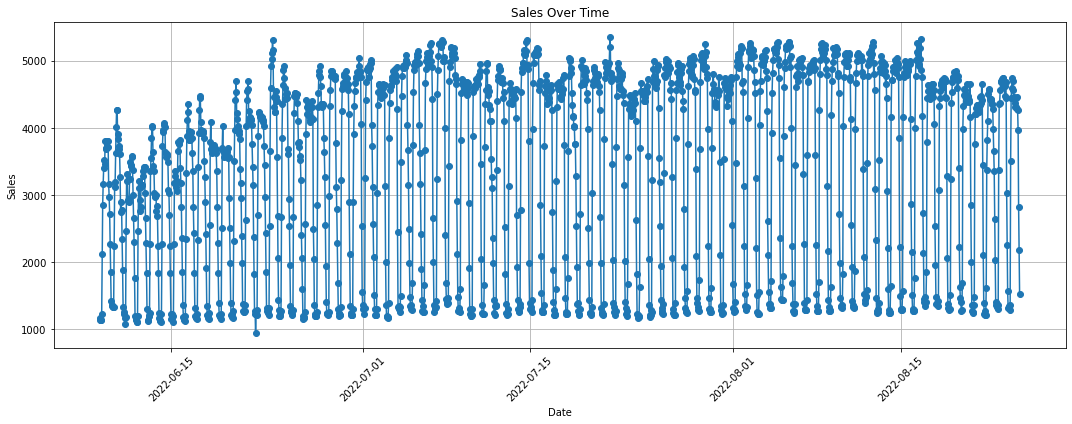

1 번 제품


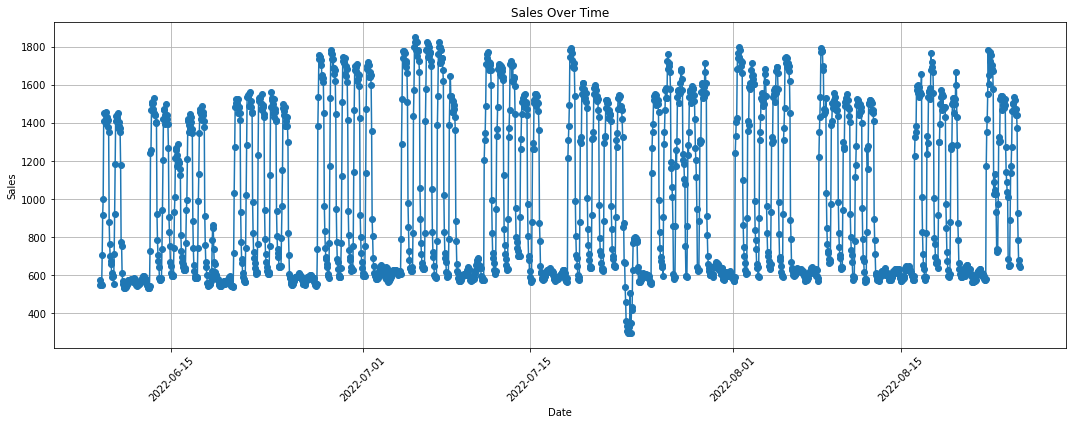

2 번 제품


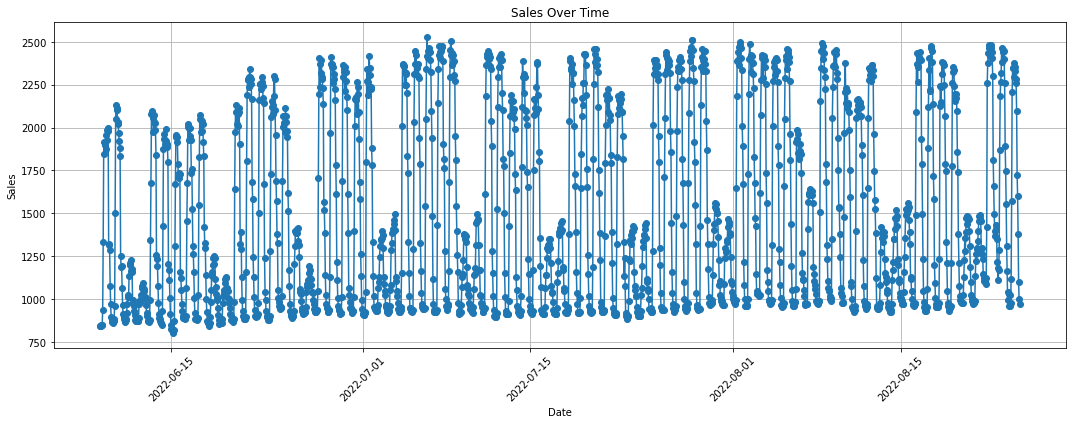

3 번 제품


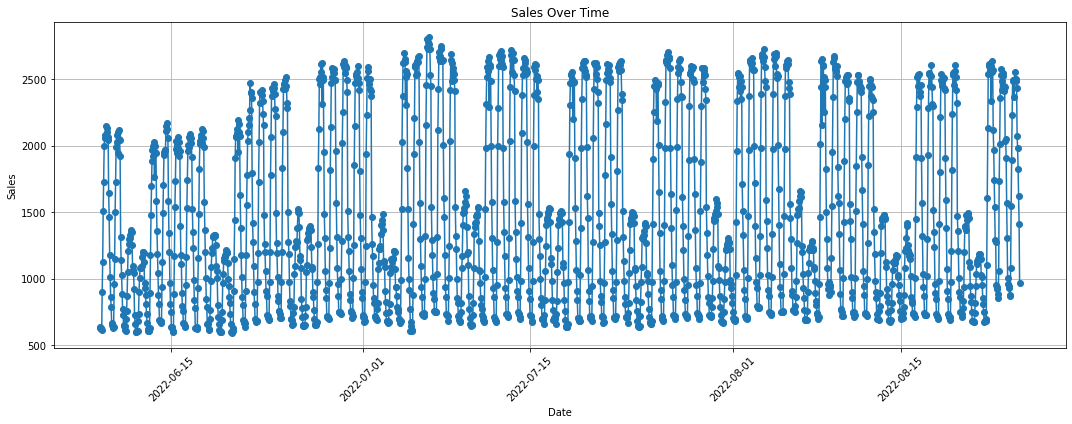

4 번 제품


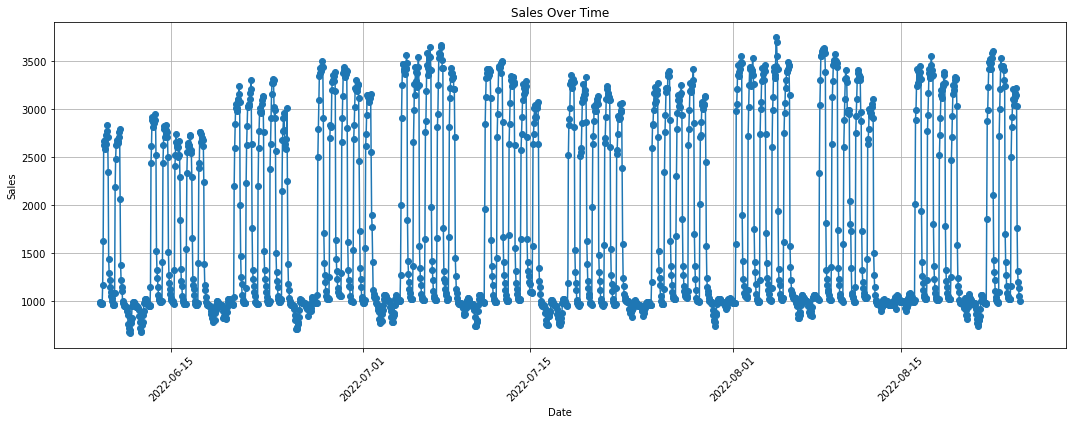

5 번 제품


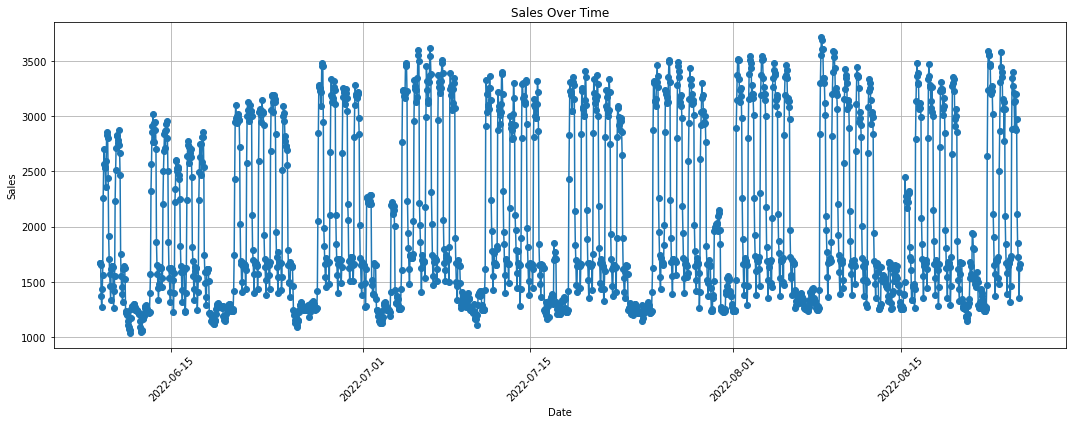

6 번 제품


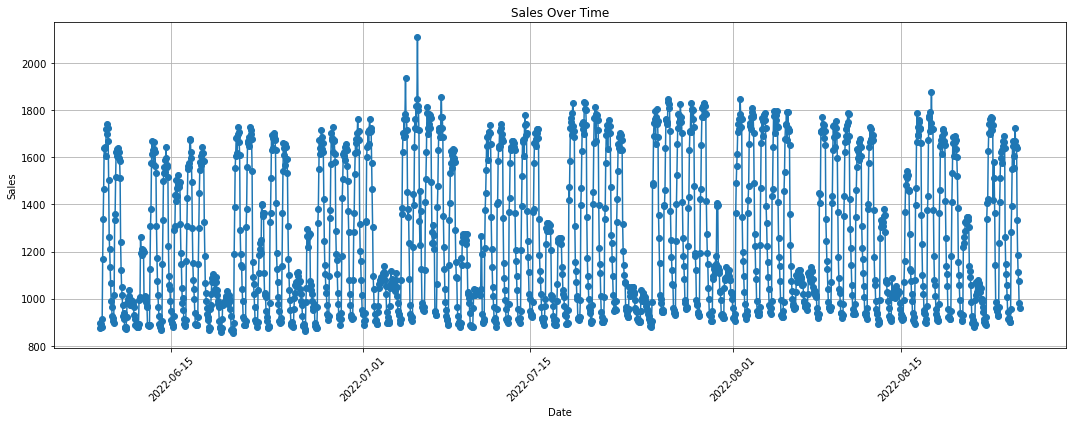

7 번 제품


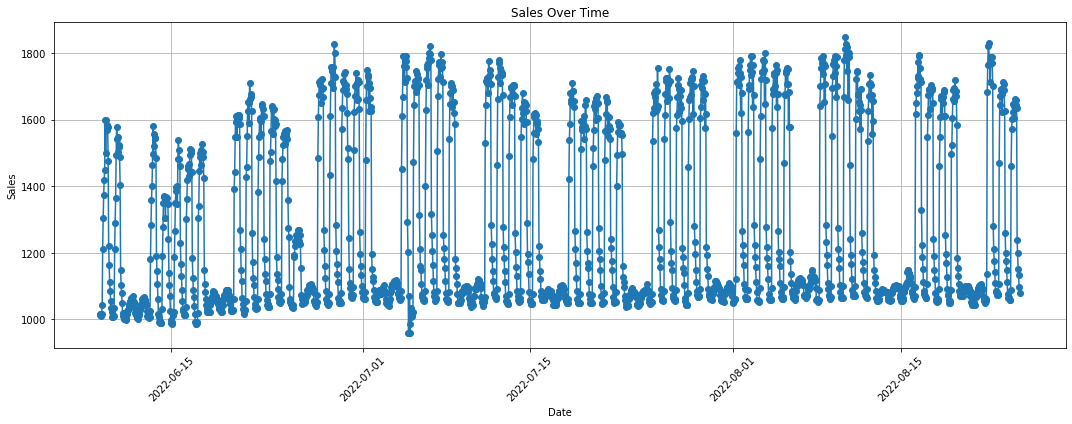

In [ ]:
for i in range(len(rows_with_high_zeros)):
    train_list[i]['date_time'] = pd.to_datetime(train_list[i]['date_time'])
    # 그래프 그리기
    plt.figure(figsize=(15, 6))
    plt.plot(train_list[i]['date_time'], train_list[i][0], marker='o')
    plt.title('Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    print(i,"번 제품")
    plt.show()